<h1 style="text-align:center;">$LIMPIEZA \ DATA \ PLAZA \ VEA$</h1>


In [ ]:
!pip install yellowbrick plotly pandas numpy scikit-learn seaborn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from joblib import dump, load
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib import gridspec
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/data_ML.csv')

In [ ]:
df.isnull().mean()

bat            0.118090
brand          0.000000
cam_front      0.128141
cam_main       0.068467
condition      0.000000
conect         0.000000
cores          0.091709
cpu_vel        0.119975
mem_int        0.027638
mem_ram        0.089196
os             0.000000
phone          0.000000
screen_size    0.138819
screen_type    0.000000
warranty       0.008794
water_res      0.000000
price_norm     0.230528
price_off      0.599246
retail         0.000000
dtype: float64

In [ ]:
df.describe()

In [ ]:
df[df['price_norm'].notnull()]

In [ ]:
#reemplazando los valores de la columna precio oferta en precio normal, despues procediendo a eliminarlos
df['price_norm'] = np.where(df['price_norm'].isnull() , df['price_off'], df['price_norm'])
df.loc[df['price_norm'] == df['price_off'], 'price_off'] = np.nan

In [ ]:
df.isnull().mean()

bat            0.000000
brand          0.000000
cam_front      0.000000
cam_main       0.000000
condition      0.000000
conect         0.000000
cores          0.000000
cpu_vel        0.000000
mem_int        0.000000
mem_ram        0.000000
os             0.000000
phone          0.000000
screen_size    0.000000
screen_type    0.000000
warranty       0.000000
water_res      0.000000
price_norm     0.000000
price_off      0.818643
retail         0.000000
dtype: float64

In [ ]:
df[df['warranty'].isnull()]

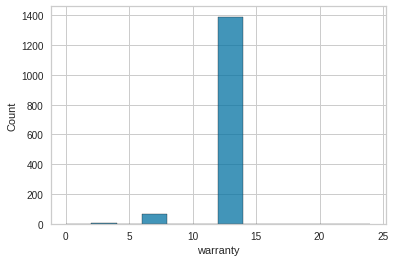

In [ ]:
sns.histplot(df[df['condition'] == 'nuevo']['warranty'])

In [ ]:
value=df['bat'].mode()[0]
value

5000.0

In [ ]:
df['bat'] = df['bat'].fillna(value=df['bat'].mode()[0])
df['cam_front'] = df['cam_front'].fillna(value=df['cam_front'].mode()[0])
df['cam_main'] = df['cam_main'].fillna(value=df['cam_main'].mode()[0])
df['cores'] = df['cores'].fillna(value=df['cores'].mode()[0])
df['cpu_vel'] = df['cpu_vel'].fillna(value=df['cpu_vel'].median())
df['mem_int'] = df['mem_int'].fillna(value=df['mem_int'].mode()[0])
df['mem_ram'] = df['mem_ram'].fillna(value=df['mem_ram'].median())
df['screen_size'] = df['screen_size'].fillna(value=df['screen_size'].median())
df['warranty'] = df['warranty'].fillna(value= 12)

In [ ]:
df = df.dropna(subset=['price_norm'])

In [ ]:
df.to_csv('data_final.csv')

### data final

In [4]:
df = pd.read_csv('/content/data_final.csv')

In [5]:
df = df.drop(columns=['phone', 'price_off','Unnamed: 0'])

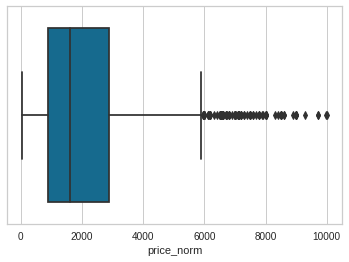

In [ ]:
sns.boxplot(df['price_norm'])

In [6]:
#Eliminando outliers
Q1 = df['price_norm'].quantile(0.25)
Q3 = df['price_norm'].quantile(0.75)
IQR = Q3 - Q1
min_value = Q1 - 1.5 * IQR
max_value = Q3 + 1.5 * IQR
df = df[(df['price_norm'] >= min_value) & (df['price_norm'] <= max_value)]

In [66]:
df['brand'].unique()

array(['samsung', 'honor', 'apple', 'xiaomi', 'motorola', 'huawei',
       'realme', 'alcatel', 'tcl', 'vivo', 'zte', 'umidigi', 'cat',
       'smooth', 'landbyte', 'verykool', 'movisun', 'lg', 'oneplus',
       'tecno', 'wiko', 'hyundai', 'generico', 'sky devices',
       'lh electronic', 'nokia', 'bmobile', 'universal', 'oppo', 'google',
       'sony', 'movisum', 'altron', 'pcd', 'tecno ', 'lenovo'],
      dtype=object)

In [7]:
def cambiar_marca(x):
  if x == 'samsung':
    return 'samsung'
  elif x == 'apple':
    return 'apple'
  elif x == 'xiaomi':
    return 'xiaomi'
  else:
    return 'otros'

In [8]:
#agrupando las marcas en menos categorias
df['brand'] = df['brand'].apply(lambda x:cambiar_marca(x))

In [9]:
# reseteando los índices
df = df.reset_index(drop=True)

In [10]:
#normalizacion standard scaler
categorical_df = df.select_dtypes(include=[np.object])
ss = StandardScaler()
numeric_df = df.select_dtypes(include=[np.number])
std_df = ss.fit_transform(numeric_df)

In [11]:
std_df = pd.DataFrame(std_df, columns=list(numeric_df.columns))

In [18]:
# Select the columns to be one-hot encoded
columns_to_encode = ['brand', 'condition', 'conect', 'os', 'screen_type', 'water_res']

# Create an OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the data with one-hot encoding
encoded_data = encoder.fit_transform(df[columns_to_encode])

# Replace the original columns with the encoded columns in the dataframe
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names(columns_to_encode))
categorical_df = categorical_df.drop(columns_to_encode, axis=1)
categorical_df = categorical_df.join(encoded_df)

In [19]:
categorical_df = categorical_df.drop(columns=['condition_reacondicionado', 'water_res_si'])

In [20]:
df2 = pd.concat([std_df,categorical_df], axis=1)
df1 = pd.concat([numeric_df,categorical_df], axis=1)

In [20]:
# Convert the dataset into a numpy array
data = df1.values

# Initialize the PCA model
pca = PCA(n_components=3)

# Fit the model to the data
pca.fit(data)

# Transform the data into the principal components
principal_components = pca.transform(data)

K-mean solo con variables númericas, estandarización standard y eliminacion de valores extremos en el precio normal

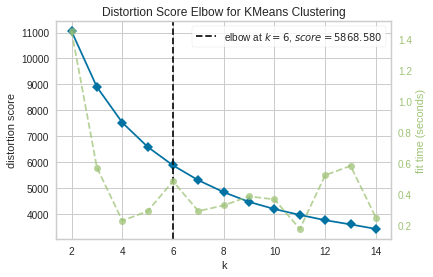

In [ ]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,15))

visualizer.fit(std_df)        # ajustamos la data al visualizador
visualizer.show() 

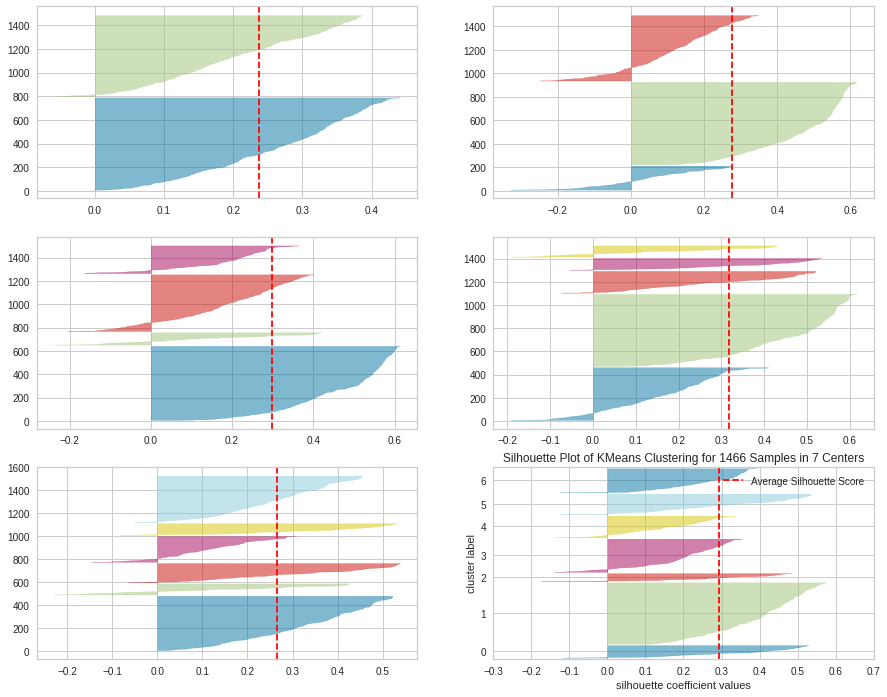

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(std_df) 
visualizer.show()

In [ ]:
# K-means
kmeans_num = KMeans(n_clusters=4)
kmeans_num.fit(std_df)
labels_std = kmeans_num.labels_
kmeans_num_silhouette = silhouette_score(std_df, labels_std)

In [ ]:
kmeans_num_silhouette

0.2972977055916205

k-mean con varaibles, numericas, min-max scaler y eliminacion de outliers en precio normal

In [12]:
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_df = scaler.fit_transform(df.select_dtypes(include=[np.number]))

# Convert the result back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df.select_dtypes(include=[np.number]).columns)

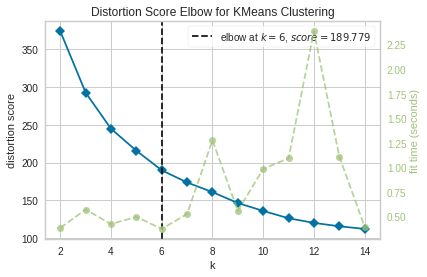

In [13]:
km1 = KMeans(random_state=42)
visualizer = KElbowVisualizer(km1, k=(2,15))

visualizer.fit(scaled_df)        # ajustamos la data al visualizador
visualizer.show() 

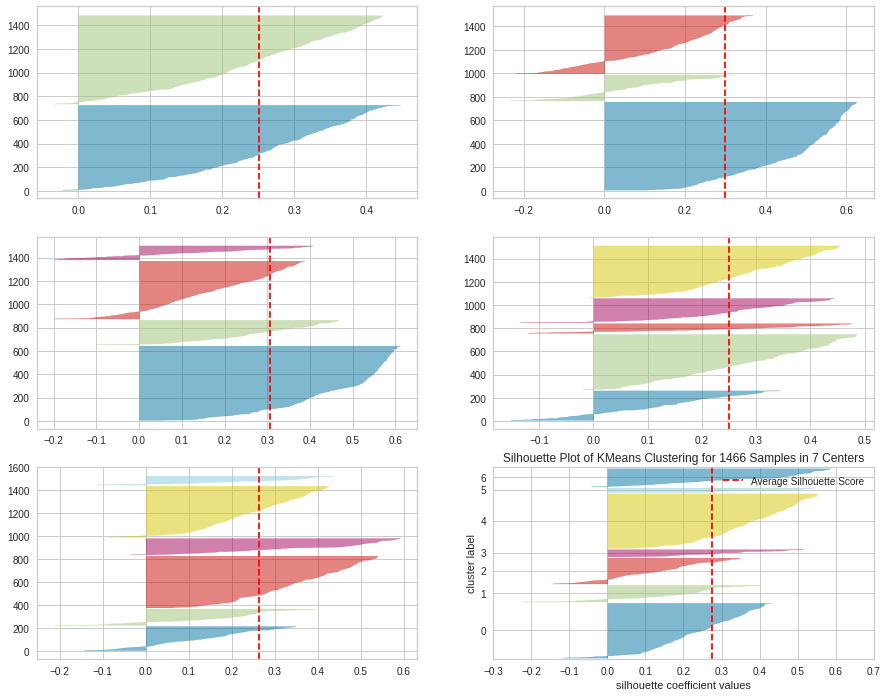

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scaled_df) 
visualizer.show()

In [15]:
# K-means-max-min-scaler
kmeans_num_scaled = KMeans(n_clusters=4)
kmeans_num_scaled.fit(scaled_df)
labels_scaled = kmeans_num_scaled.labels_
kmeans_num_silhouette_scaled = silhouette_score(scaled_df, labels_scaled)

In [16]:
kmeans_num_silhouette_scaled

0.30807658631664836

Kmean con con varaibles categoricas como numericas

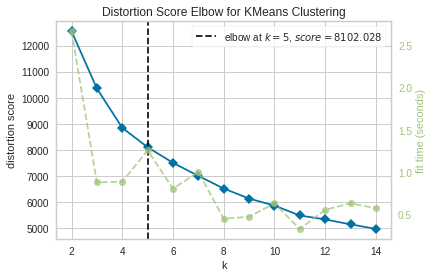

In [31]:
km1 = KMeans(random_state=42)
visualizer = KElbowVisualizer(km1, k=(2,15))

visualizer.fit(df2)        # ajustamos la data al visualizador
visualizer.show() 

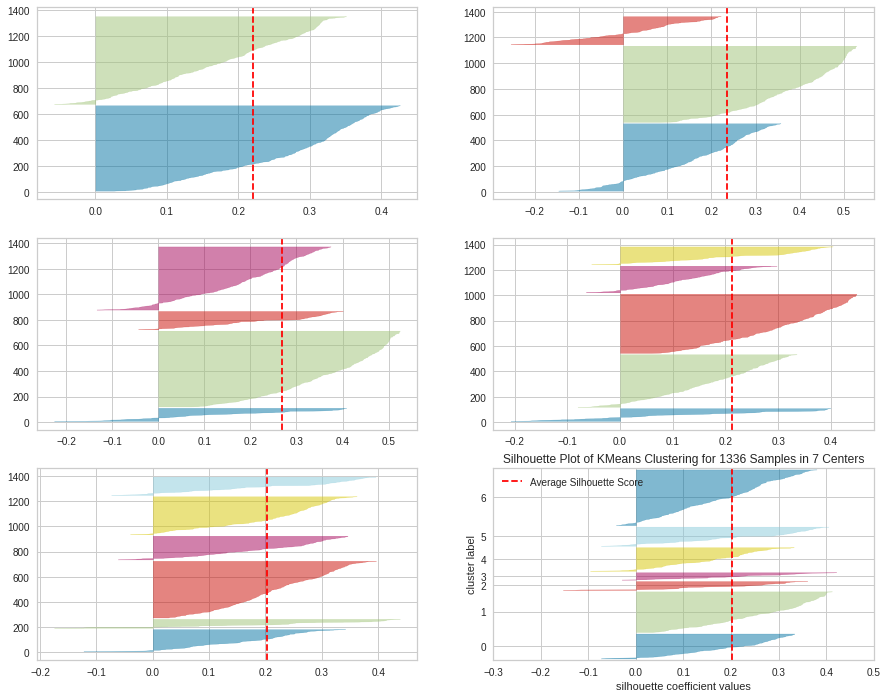

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=200, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df2) 
visualizer.show()

In [38]:
# K-means-max-min-scaler
kmeans_scaled = KMeans(n_clusters=4)
kmeans_scaled.fit(df2)
labels_scaled_1 = kmeans_num_scaled.labels_
kmeans_silhouette_scaled = silhouette_score(df2, labels_scaled_1)

In [39]:
kmeans_silhouette_scaled

0.1848297043734263

hierarchical clustering con std scaler

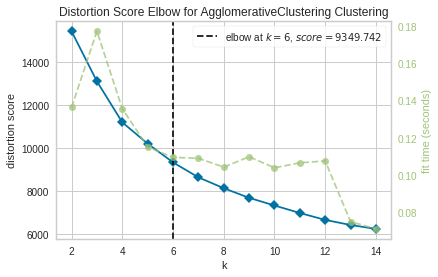

In [ ]:
km2 = AgglomerativeClustering()
visualizer = KElbowVisualizer(km2, k=(2,15))

visualizer.fit(df2)        # ajustamos la data al visualizador
visualizer.show() 

In [ ]:
# Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(df2)
agg_silhouette = silhouette_score(df2, agg_labels)

In [ ]:
agg_silhouette

0.20472020442068145

DBSCAN 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

silhouette_scorer = make_scorer(silhouette_score)

# Create the parameter grid
param_grid = {
    'eps': np.arange(0.1, 1.0, 0.1),
    'min_samples': [5, 10, 15, 20],
}

# Create an instance of the DBSCAN model
dbscan = DBSCAN()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(dbscan, param_grid, cv=5, scoring=silhouette_scorer)

# Fit the GridSearchCV model to the data
grid_search.fit(df2)

# Get the best combination of hyperparameters
best_params = grid_search.best_params_

# Use the best hyperparameters to create a new instance of the DBSCAN model
best_dbscan = DBSCAN(**best_params)

In [ ]:
best_dbscan.fit(df2)

DBSCAN(eps=0.1)

In [ ]:
# Get the labels for each data point
labels = best_dbscan.labels_

# Get the Silhouette Score
silhouette_score = silhouette_score(df2, labels)

In [ ]:
silhouette_score

-0.33318106745847864

Agregando la variable cluster

In [28]:
df1['cluster'] = labels_scaled

In [29]:
df1['cluster'].unique()

array([0, 3, 1, 2], dtype=int32)

In [32]:
df1.loc[df1['cluster'] == 0, 'cluster'] = 'gamma media baja'
df1.loc[df1['cluster'] == 1, 'cluster'] = 'gamma alta'
df1.loc[df1['cluster'] == 2, 'cluster'] = 'gamma baja'
df1.loc[df1['cluster'] == 3, 'cluster'] = 'gamma media alta'

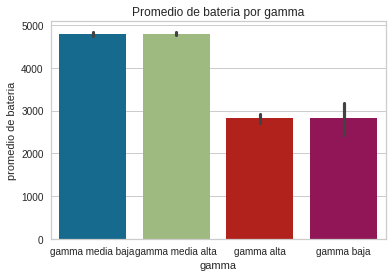

In [40]:
sns.barplot(x = 'cluster', y = 'bat', data = df1)
plt.title('Promedio de bateria por gamma')
plt.xlabel('gamma')
plt.ylabel('promedio de bateria')

# Display the plot
plt.show()

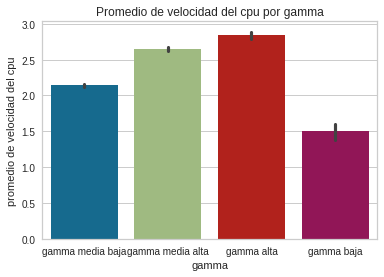

In [41]:
sns.barplot(x = 'cluster', y = 'cpu_vel', data = df1)
plt.title('Promedio de velocidad del cpu por gamma')
plt.xlabel('gamma')
plt.ylabel('promedio de velocidad del cpu')

# Display the plot
plt.show()

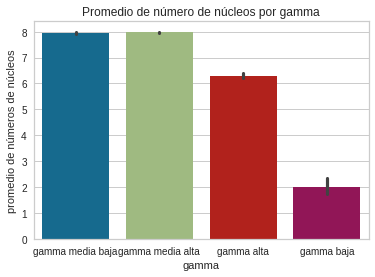

In [43]:
sns.barplot(x = 'cluster', y = 'cores', data = df1)
plt.title('Promedio de número de núcleos por gamma')
plt.xlabel('gamma')
plt.ylabel('promedio de números de núcleos')

# Display the plot
plt.show()

In [54]:
df1.groupby(['cluster']).mean()

,bat,cam_front,cam_main,cores,cpu_vel,mem_int,mem_ram,screen_size,warranty,price_norm,...,os_emui,os_freedos,os_ios,screen_type_amoled,screen_type_dynamic amoled,screen_type_ips,screen_type_oled,screen_type_super amoled,screen_type_super retina xdr oled,water_res_no
cluster,,,,,,,,,,,,,,,,,,,,,
0,2456.480769,10.032051,10.703846,6.371795,2.610000,115.128615,3.830538,5.281538,7.769231,1984.391026,...,0.000000,0.083333,0.801282,0.019231,0.000000,0.685897,0.025641,0.012821,0.256410,0.089744
1,4770.488798,21.395112,71.433809,7.971487,2.611843,178.835031,7.490835,6.441079,11.474542,2356.336049,...,0.010183,0.000000,0.000000,0.606925,0.061100,0.160896,0.061100,0.107943,0.002037,0.138493
2,4815.860927,9.965232,36.791722,7.940397,2.134321,86.836199,3.903252,6.315728,11.759934,920.721838,...,0.044702,0.014901,0.000000,0.144040,0.001656,0.798013,0.021523,0.029801,0.004967,0.316225
3,2845.294118,7.944706,8.964706,1.941176,1.502118,38.645082,2.362729,4.245765,11.352941,341.492941,...,0.082353,0.482353,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.623529


In [30]:
df_group = df1.groupby(['cluster']).mean()

In [31]:
df_group.to_csv('df_agrupado.csv')